In [2]:
from pymongo import MongoClient
import pprint
import pandas as pd
# Requests sends and recieves HTTP requests.
import requests
import json
import time

In [3]:
import matplotlib.pyplot as plt

In [4]:
client = MongoClient('localhost', 27017)
results = client['results']
runners = results['indiv']
new = client['new_db']
indiv = new['individual']

In [5]:
results.list_collection_names()

['indiv', 'source']

In [6]:
len(list(runners.find()))

19311

In [7]:
### Create dataframe from indiv results collection, converts time to seconds
df = pd.DataFrame(list(runners.find()))
df.head()
df['Time(sec)'] = pd.to_timedelta(df['time']).astype('timedelta64[s]').astype(int)#.map('{:,.2f}'.format)
df.head()

,_id,name,time,age,ag,dist,Time(sec)
0,5f170b3bc94e506c54092382,Abdi Abdirahman,2:11:34,42,Men 40-44,Mar,7894
1,5f170b3bc94e506c54092383,Mustafa Mohamed,2:19:41,40,Men 40-44,Mar,8381
2,5f170b3bc94e506c54092384,Fredison Costa,2:21:29,42,Men 40-44,Mar,8489
3,5f170b3bc94e506c54092385,Vladimir Shatrov,2:26:17,41,Men 40-44,Mar,8777
4,5f170b3bc94e506c54092386,Miguel Ferrer,2:27:15,41,Men 40-44,Mar,8835


In [20]:
##set up 4 diff DF
agroup = ['Men 40-44', 'Men 45-49', 'Women 25-29', 'Women 30-34']
dist = ['Mar', 'Mar', 'Mile', 'Mile']

#M_Mar = df[df['ag']=='Men 40-44'& df['dist']=='Mar']

M_Mar = df[df.ag.isin(agroup[:2]) & 
           df.dist.isin(dist[:2])]
W_Mar = df[df.ag.isin(agroup[2:]) & 
           df.dist.isin(dist[:2])]
M_Mile = df[df.ag.isin(agroup[:2]) & 
           df.dist.isin(dist[2:])]
W_Mile = df[df.ag.isin(agroup[2:]) & 
           df.dist.isin(dist[2:])]

In [24]:
def add_quantile(df):
    cutoff = df['Time(sec)'].quantile(.75)
    df['upper quartiles'] = df['Time(sec)']<cutoff
    return df

    
raw_list_df = [M_Mar, W_Mar, M_Mile, W_Mile]

quant_list = [add_quantile(x) for x in raw_list_df]

quant_list[0].tail()



[                           _id              name     time  age         ag  \
0     5f170b3bc94e506c54092382   Abdi Abdirahman  2:11:34   42  Men 40-44   
1     5f170b3bc94e506c54092383   Mustafa Mohamed  2:19:41   40  Men 40-44   
2     5f170b3bc94e506c54092384    Fredison Costa  2:21:29   42  Men 40-44   
3     5f170b3bc94e506c54092385  Vladimir Shatrov  2:26:17   41  Men 40-44   
4     5f170b3bc94e506c54092386     Miguel Ferrer  2:27:15   41  Men 40-44   
...                        ...               ...      ...  ...        ...   
9696  5f1711aac94e506c54094963  Derrick Lawrence  8:04:11   49  Men 45-49   
9697  5f1711aac94e506c54094964       Paul Biguvu  8:04:12   46  Men 45-49   
9698  5f1711aac94e506c54094965  Joseph Frederick  8:11:31   47  Men 45-49   
9699  5f1711aac94e506c54094966      Steve Dubois  8:15:53   49  Men 45-49   
9700  5f1711aac94e506c54094967      Tane Walters  8:22:20   46  Men 45-49   

     dist  Time(sec)  upper quartiles  
0     Mar       7894             T

/Users/annebarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


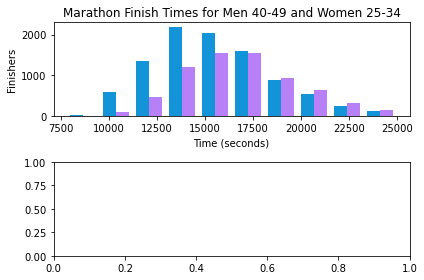

In [48]:
fig,ax = plt.subplots(2,1)

## marathon data
ax[0].hist([quant_list[0]['Time(sec)'], quant_list[1]['Time(sec)']], bins = 10, range = (7800,25000), align = ('mid'), color = ['#1494D8','#B780F6'], label = ['Men', 'Women'])   
ax[0].spines["bottom"].set_visible(True)      
ax[0].spines["left"].set_visible(True)
#plt.xticks(fontsize=30)
ax[0].set_title('Marathon Finish Times for Men 40-49 and Women 25-34')
ax[0].set_xlabel('Time (seconds)')
ax[0].set_ylabel('Finishers')

##
ax[1].hist([quant_list[2]['Time(sec)'], quant_list[3]['Time(sec)']], bins = 10, range = (7800,25000), align = ('mid'), color = ['#1494D8','#B780F6'], label = ['Men', 'Women'])   
ax[1].spines["bottom"].set_visible(True)      
ax[1].spines["left"].set_visible(True)
#plt.xticks(fontsize=30)
ax[1].set_title('Marathon Finish Times for Men 40-49 and Women 25-34')
ax[1].set_xlabel('Time (seconds)')
ax[1].set_ylabel('Finishers')

fig.tight_layout()

ValueError: cannot copy sequence with size 405 to array axis with dimension 8

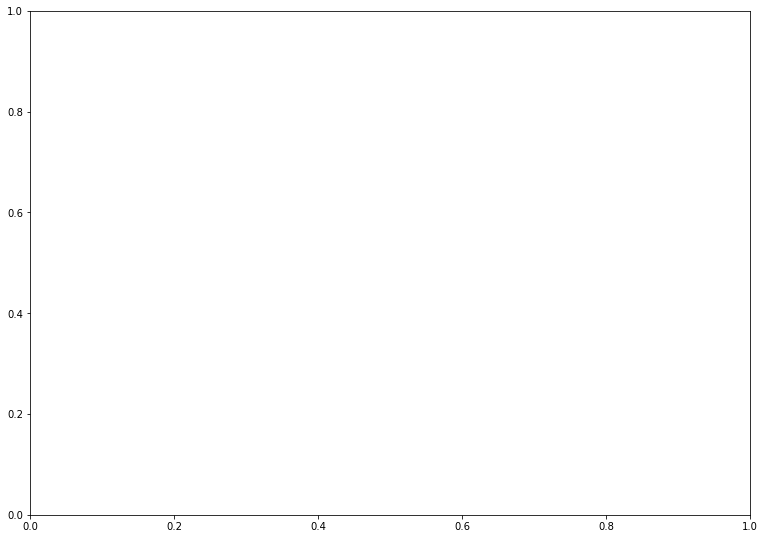

In [163]:

fig,ax = plt.subplots(figsize =(10, 7)) 
ax = fig.add_axes([0, 0, 1, 1]) 

bp = ax.boxplot(data) 
  
# show plot 
plt.show() 